In [1]:
import tensorflow as tf
print(tf.__version__)

import os
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import control_flow_ops

1.9.0


# Autoencoder

Autoencoder is the better way to decrease data dimensions.

## Network

In [11]:
def layer_batch_norm(x, n_out, phase_train):
    """
    Batch Normalization
    """
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("alpha", [n_out], initializer=gamma_init)
    
    #batch_mean, batch_var = tf.nn.moments(x, len(x.shape())-1, name='moments')
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    
    x_r = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(x_r, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [12]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0/weight_shape[0])**0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [13]:
def encoder(input, n_code, phase_train):
    with tf.variable_scope("encoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(input, [784, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
        
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
        
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)
            
        with tf.variable_scope("embedding"):
            embedding = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)
            
        return embedding

In [14]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_decoder_hidden_1], [n_decoder_hidden_1], phase_train)
            
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_decoder_hidden_1, n_decoder_hidden_2], [n_decoder_hidden_2], phase_train)
            
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_decoder_hidden_2, n_decoder_hidden_3], [n_decoder_hidden_3], phase_train)
            
        with tf.variable_scope("output"):
            output = layer(hidden_3, [n_decoder_hidden_3, 784], [784], phase_train)
        
        return output

## Target

In [15]:
def loss(output, x):
    with tf.variable_scope("training"):
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_loss = tf.reduce_mean(l2)
        train_summary_opt = tf.summary.scalar("train_cost", train_loss)
        return train_loss, train_summary_opt

In [16]:
def training(cost, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, \
                                       beta1=9e-1, \
                                       beta2=0.999, \
                                       epsilon=1e-8, \
                                       use_locking=False, \
                                       name="Adam")
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [17]:
def image_summary(summary_label, tensor):
    reshape = tf.reshape(tensor, [-1, 28, 28, 1])
    return tf.summary.image(summary_label, reshape)

In [18]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        in_img_op = image_summary("input_image", x)
        ou_img_op = image_summary("output_image", output)
        l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_loss = tf.reduce_mean(l2)
        val_summary_opt = tf.summary.scalar("val_loss",val_loss)
        return val_loss, in_img_op, ou_img_op, val_summary_opt

In [19]:
full_training = True
n_code = 2
n_encoder_hidden_1 = 1000
n_encoder_hidden_2 = 500
n_encoder_hidden_3 = 250
n_decoder_hidden_1 = 250
n_decoder_hidden_2 = 500
n_decoder_hidden_3 = 1000
batch_size = 64
training_epochs = 1000 if full_training else 1
batch_size = 100 if full_training else 1000
display_step = 1000 if full_training else 100

## Training

In [11]:
def start_autoencoder(embedding=2):
    n_code = embedding
    mnist = input_data.read_data_sets("/notebooks/devops/tmp/MNIST_data/", one_hot=True)
    
    with tf.Graph().as_default():
        with tf.variable_scope("autoencoder"):
            x = tf.placeholder("float", [None, 784])
            phase_train = tf.placeholder(tf.bool)
            
            embedding = encoder(x, n_code=n_code, phase_train=phase_train)
            output = decoder(embedding, n_code=n_code, phase_train=phase_train)
            
            cost, train_summary_opt = loss(output, x)
            
            global_step = tf.Variable(0, name="global_step", trainable=False)
            train_op = training(cost=cost, global_step=global_step)
            
            eval_op, in_img, out_img, eval_summary = evaluate(output=output, x=x)
            suumary = tf.summary.merge_all()
            
            saver = tf.train.Saver(max_to_keep=200)
            
            default_path = "/notebooks/devops/tmp/basic_tf/basic_embedding"
            with tf.Session() as sess:
                train_writer = tf.summary.FileWriter(\
                    os.path.join(default_path, "mnist_autoencoder_hidden_" + str(n_code) + "_logs"), graph=sess.graph)
                eval_writer = tf.summary.FileWriter(\
                    os.path.join(default_path, "mnist_autoencoder_hidden_" + str(n_code) + "_logs"), graph=sess.graph)
            
                sess.run(tf.initialize_all_variables())
                
                for epoch in range(training_epochs):
                    
                    avg_cost = 0.
                    total_batch = int(mnist.train.num_examples / batch_size)
                    
                    for idx in range(total_batch):
                        batch_x, batch_y = mnist.train.next_batch(batch_size)
                        _, train_loss, train_summary = sess.run(\
                            [train_op, cost, train_summary_opt], \
                            feed_dict={x: batch_x, phase_train: True})
                        
                        train_writer.add_summary(train_summary, sess.run(global_step))
                        
                        avg_cost += (train_loss / total_batch)
                        
                    if epoch & display_step == 0:
                        print("Step:", sess.run(global_step), "Cost:", avg_cost)
                        
                        train_writer.add_summary(train_summary, sess.run(global_step))
                        val_images = mnist.validation.images
                        
                        val_loss, val_im_img, val_out_img, val_summary = \
                            sess.run([eval_op, in_img, out_img, eval_summary], \
                            feed_dict = {x: val_images, phase_train: False})
                
                        eval_writer.add_summary(val_im_img, sess.run(global_step))
                        eval_writer.add_summary(val_out_img, sess.run(global_step))
                        eval_writer.add_summary(val_summary, sess.run(global_step))
                        print("Validation error:", val_loss)
                        print("Global_step:", sess.run(global_step))
                        
                        saver.save(sess, os.path.join(default_path, 'model-checkpoint'), global_step = global_step)
                        
                print("Optimization finished.")
                
                test_loss = sess.run(eval_op, feed_dict={x: mnist.test.images, phase_train: False})
                print("Test:", test_loss)

In [12]:
start_autoencoder()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/jiankaiwang/Desktop/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step: 550 Cost: 11.545185340534552
Validation error: 9.033014
Global_step: 

KeyboardInterrupt: 

# Compare to PCA

The non-nn way to decrease data dimensions.

In [20]:
from sklearn import decomposition
from matplotlib import pyplot as plt

In [21]:
mnist = input_data.read_data_sets("/notebooks/devops/tmp/MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /notebooks/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /notebooks/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [22]:
pca = decomposition.PCA(n_components=2)
pca.fit(mnist.train.images)
pca_codes = pca.transform(mnist.test.images)

In [23]:
pca_codes.shape

(10000, 2)

In [24]:
pca_codes[:2]

array([[-1.3160164 ,  2.9330697 ],
       [ 0.08079973, -3.775074  ]], dtype=float32)

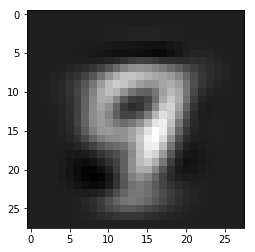

In [25]:
pca_rev = pca.inverse_transform(pca_codes[:1])
plt.imshow(pca_rev[0].reshape(28,28), cmap=plt.cm.gray)
plt.show()

In [30]:
def scatter(codes, labels):
    color = [\
            ['#27ae60', 'o'], \
            ['#2980b9', 'o'], \
            ['#8e44ad', 'o'], \
            ['#f39c12', 'o'], \
            ['#c0392b', 'o'], \
            ['#27ae60', 'x'], \
            ['#2980b9', 'x'], \
            ['#8e44ad', 'x'], \
            ['#f39c12', 'x'], \
            ['#c0392b', 'x'], \
            ]
    for num in range(10):
        plt.scatter([codes[:,0][i] for i in range(len(labels)) if labels[i] == num], \
                   [codes[:,1][i] for i in range(len(labels)) if labels[i] == num], 7, \
                   label=str(num), color=color[num][0], marker=color[num][1])
    plt.legend()
    plt.show()

INFO:tensorflow:Restoring parameters from /notebooks/devops/tmp/basic_tf/basic_embedding/model-checkpoint-13200


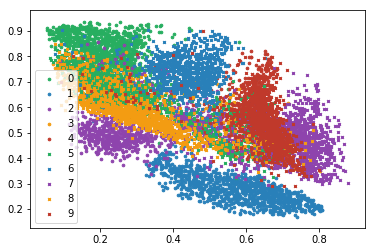

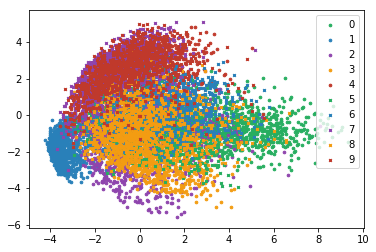

In [31]:
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder"):
        x = tf.placeholder("float", [None, 784])
        phase_train = tf.placeholder(tf.bool)
        
        embedding = encoder(x, 2, phase_train)
        output = decoder(embedding, 2, phase_train)
        
        cost, train_summary_opt = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        
        train_op = training(cost, global_step)
        eval_op, in_img, out_img, eval_summary = evaluate(output=output, x=x)
        
        saver = tf.train.Saver()
        
        model_path = '/notebooks/devops/tmp/basic_tf/basic_embedding/model-checkpoint-13200'
        with tf.Session() as sess:
            saver.restore(sess, model_path)
        
            ae_code = sess.run(embedding, feed_dict={x: mnist.test.images, phase_train: True})
            
            scatter(ae_code, mnist.test.labels)
            scatter(pca_codes, mnist.test.labels)

In [32]:
mnist.test.labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

# Denoising Autoencoder

The process is similar with regular autoencoder but to random dropout data points in input layer.

In [51]:
def corrupt_input(x):
    corrupting_matrix = tf.random_uniform(shape=tf.shape(x), minval=0, maxval=2, dtype=tf.float32)
    return x * tf.cast(corrupting_matrix, tf.float32)

def start_denoising_autoencoder(embedding=2):
    n_code = embedding
    mnist = input_data.read_data_sets("/notebooks/devops/tmp/MNIST_data/", one_hot=True)
    
    with tf.Graph().as_default():
        with tf.variable_scope("autoencoder"):
            x = tf.placeholder("float", [None, 784])
            
            # denoising
            corrput = tf.placeholder(tf.float32)
            xc = (corrupt_input(x) * corrput) + (x * (1 - corrput))
            phase_train = tf.placeholder(tf.bool)
            
            embedding = encoder(xc, n_code=n_code, phase_train=phase_train)
            output = decoder(embedding, n_code=n_code, phase_train=phase_train)
            
            cost, train_summary_opt = loss(output, xc)
            
            global_step = tf.Variable(0, name="global_step", trainable=False)
            train_op = training(cost=cost, global_step=global_step)
            
            eval_op, in_img, out_img, eval_summary = evaluate(output=output, x=xc)
            suumary = tf.summary.merge_all()
            
            saver = tf.train.Saver(max_to_keep=200)
            
            default_path = "/notebooks/devops/tmp/basic_tf/basic_denoising_embedding"
            with tf.Session() as sess:
                train_writer = tf.summary.FileWriter(\
                    os.path.join(default_path, "mnist_autoencoder_hidden_" + str(n_code) + "_logs"), graph=sess.graph)
                eval_writer = tf.summary.FileWriter(\
                    os.path.join(default_path, "mnist_autoencoder_hidden_" + str(n_code) + "_logs"), graph=sess.graph)
            
                sess.run(tf.initialize_all_variables())
                
                for epoch in range(training_epochs):
                    
                    avg_cost = 0.
                    total_batch = int(mnist.train.num_examples / batch_size)
                    
                    for idx in range(total_batch):
                        batch_x, batch_y = mnist.train.next_batch(batch_size)
                        _, train_loss, train_summary = sess.run(\
                            [train_op, cost, train_summary_opt], \
                            feed_dict={x: batch_x, phase_train: True, corrput: 1})
                        
                        train_writer.add_summary(train_summary, sess.run(global_step))
                        
                        avg_cost += (train_loss / total_batch)
                        
                    if epoch & display_step == 0:
                        print("Step:", sess.run(global_step), "Cost:", avg_cost)
                        
                        train_writer.add_summary(train_summary, sess.run(global_step))
                        val_images = mnist.validation.images
                        
                        val_loss, val_im_img, val_out_img, val_summary = \
                            sess.run([eval_op, in_img, out_img, eval_summary], \
                            feed_dict = {x: val_images, phase_train: False, corrput: 1})
                
                        eval_writer.add_summary(val_im_img, sess.run(global_step))
                        eval_writer.add_summary(val_out_img, sess.run(global_step))
                        eval_writer.add_summary(val_summary, sess.run(global_step))
                        print("Validation error:", val_loss)
                        print("Global_step:", sess.run(global_step))
                        
                        saver.save(sess, os.path.join(default_path, 'model-checkpoint'), global_step = global_step)
                        
                print("Optimization finished.")
                
                test_loss = sess.run(eval_op, feed_dict={x: mnist.test.images, phase_train: False, corrput: 1})
                print("Test:", test_loss)

In [52]:
start_denoising_autoencoder()

Extracting /notebooks/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Step: 550 Cost: 12.741439049460682
Validation error: 11.323489
Global_step: 550
Step: 1100 Cost: 10.871031918959185
Validation error: 10.096017
Global_step: 1100
Step: 1650 Cost: 10.001623113805605
Validation error: 10.41855
Global_step: 1650
Step: 2200 Cost: 9.541616503975606
Validation error: 9.291683
Global_step: 2200
Step: 2750 Cost: 9.228953162106597
Validation error: 9.070709
Global_step: 2750
Step: 3300 Cost: 9.004698772430416
Validation error: 8.797408
Global_step: 3300
Step: 3850 Cost: 8.82381815650245
Validation error: 8.697924
Global_step: 3850
Step: 4400 Cost: 8.650692617242992
Validation error: 8.498626
Global_step: 4400
Step: 9350 Cost: 7.9215355508977705
Validation error: 7.8257384
Global_step:

KeyboardInterrupt: 